<a href="https://colab.research.google.com/github/Witcape/3D_Printing/blob/main/Final_Results/ALL_PARAMS_VIT_CLAHE_FINAL_CROPPED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/AarohiSingla/Image-Classification-Using-Vision-transformer
%cd Image-Classification-Using-Vision-transformer

fatal: destination path 'Image-Classification-Using-Vision-transformer' already exists and is not an empty directory.
/content/Image-Classification-Using-Vision-transformer


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head
class_names = ['Normal','Spaghetti','Stringing']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

In [5]:
!pip install torchinfo
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

#### Notice how only the output layer is trainable, where as, all of the rest of the layers are untrainable (frozen).

In [6]:
# Setup directory paths to train and test images
train_dir = '/content/drive/MyDrive/Final_Cropped/Train'
test_dir = '/content/drive/MyDrive/Final_Cropped/Test'

In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

Remember, if you're going to use a pretrained model, it's generally important to ensure your own custom data is transformed/formatted in the same way the data the original model was trained on.

In [8]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


## And now we've got transforms ready, we can turn our images into DataLoaders using the create_dataloaders()

In [9]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [10]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [11]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6025 | train_acc: 0.7721 | test_loss: 0.2656 | test_acc: 0.9609
Epoch: 2 | train_loss: 0.2985 | train_acc: 0.8971 | test_loss: 0.1740 | test_acc: 0.9531
Epoch: 3 | train_loss: 0.1992 | train_acc: 0.9421 | test_loss: 0.1548 | test_acc: 0.9531
Epoch: 4 | train_loss: 0.1670 | train_acc: 0.9504 | test_loss: 0.1414 | test_acc: 0.9531
Epoch: 5 | train_loss: 0.1425 | train_acc: 0.9605 | test_loss: 0.1350 | test_acc: 0.9609
Epoch: 6 | train_loss: 0.1381 | train_acc: 0.9678 | test_loss: 0.1262 | test_acc: 0.9609
Epoch: 7 | train_loss: 0.1180 | train_acc: 0.9669 | test_loss: 0.1200 | test_acc: 0.9688
Epoch: 8 | train_loss: 0.1026 | train_acc: 0.9761 | test_loss: 0.1137 | test_acc: 0.9688
Epoch: 9 | train_loss: 0.0933 | train_acc: 0.9789 | test_loss: 0.1101 | test_acc: 0.9688
Epoch: 10 | train_loss: 0.0833 | train_acc: 0.9835 | test_loss: 0.1135 | test_acc: 0.9688


In [12]:
# From DataLoader (dynamic computation)
train_size = sum(len(batch[1]) for batch in train_dataloader_pretrained)  # Assuming batch[1] is labels
test_size = sum(len(batch[1]) for batch in test_dataloader_pretrained)

print(f"Total training samples: {train_size}")
print(f"Total testing samples: {test_size}")


Total training samples: 1057
Total testing samples: 128


pretrained ViT performed far better than our custom ViT model trained from scratch (in the same amount of time).


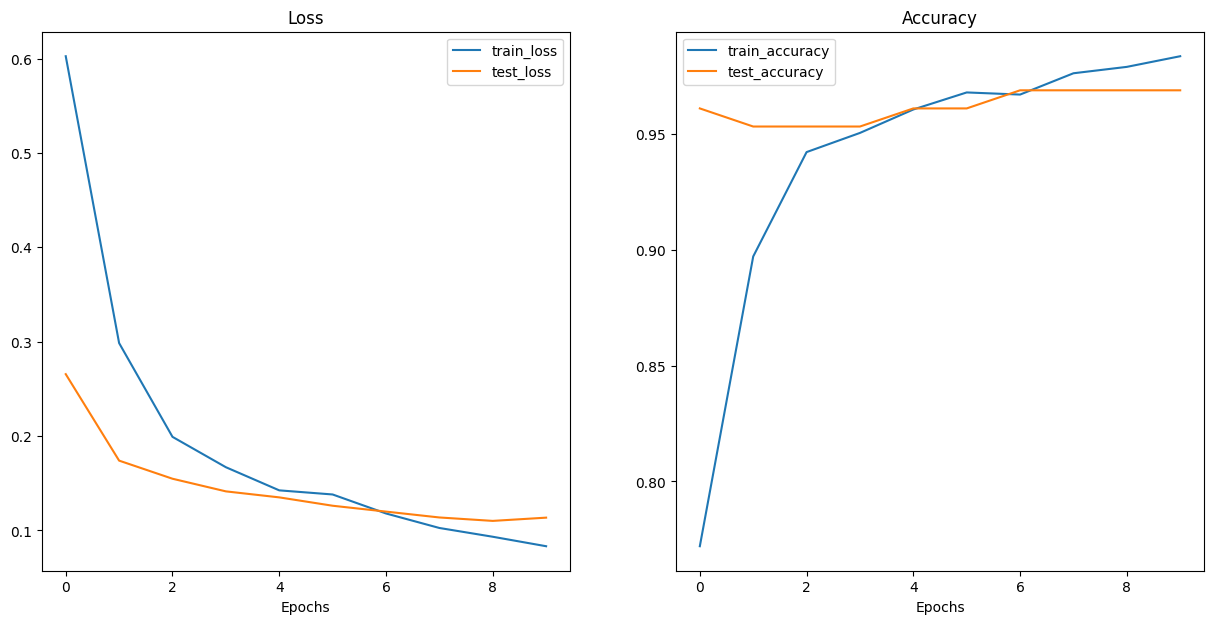

In [13]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

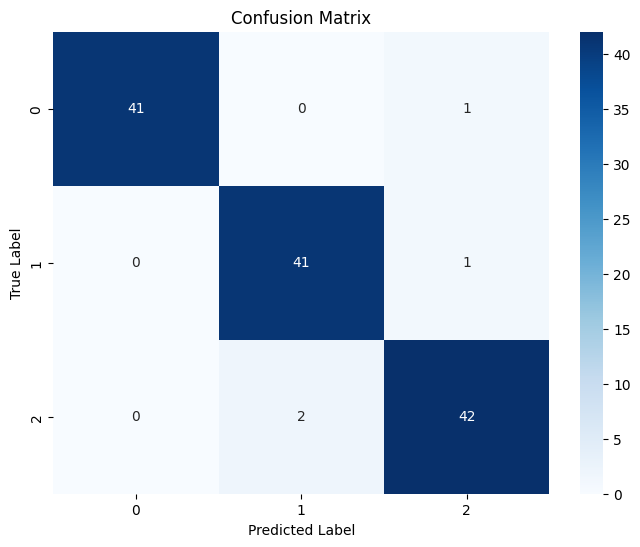

In [14]:
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set model to evaluation mode
pretrained_vit.eval()

# Disable gradient calculations (inference only)
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_dataloader_pretrained:
        images, labels = images.to(device), labels.to(device)

        # Forward pass: Get predictions
        outputs = pretrained_vit(images)
        _, predicted = torch.max(outputs, 1)

        # Store predictions and true labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [15]:
# Set model to evaluation mode
pretrained_vit.eval()

# Disable gradient calculations (inference only)
with torch.no_grad():
    correct = 0
    total = 0

    for images, labels in test_dataloader_pretrained:
        images, labels = images.to(device), labels.to(device)

        # Forward pass: Get predictions
        outputs = pretrained_vit(images)
        _, predicted = torch.max(outputs, 1)

        # Update total and correct counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate accuracy
accuracy = correct / total * 100
print(f'Accuracy on the test dataset: {accuracy:.2f}%')


Accuracy on the test dataset: 96.88%


# RESULTS

In [16]:
import torch
from sklearn.metrics import (confusion_matrix, precision_score, recall_score, f1_score,
                             matthews_corrcoef, cohen_kappa_score)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
num_classes = conf_matrix.shape[0]

# Initialize variables for overall metrics
total_TP, total_FN, total_TN, total_FP = 0, 0, 0, 0

# Extract TN, FP, FN, TP and calculate per-class metrics
per_class_metrics = []
for i in range(num_classes):
    TP = conf_matrix[i, i]
    FN = conf_matrix[i, :].sum() - TP
    FP = conf_matrix[:, i].sum() - TP
    TN = conf_matrix.sum() - (TP + FP + FN)

    # Accumulate overall values
    total_TP += TP
    total_FN += FN
    total_FP += FP
    total_TN += TN

    # Append per-class metrics
    per_class_metrics.append({
        'class': f'Class {i}',
        'accuracy': (TP + TN) / (TP + TN + FP + FN),
        'sensitivity': TP / (TP + FN) if (TP + FN) > 0 else 0,  # Avoid division by zero
        'specificity': TN / (TN + FP) if (TN + FP) > 0 else 0,  # Avoid division by zero
    })

print("True Positives (TP):", TP)
print("False Negatives (FN):", FN)
print("False Positives (FP):", FP)
print("True Negatives (TN):", TN)

True Positives (TP): 42
False Negatives (FN): 2
False Positives (FP): 2
True Negatives (TN): 82


In [17]:
accuracy = np.trace(conf_matrix) / conf_matrix.sum()
sensitivity = total_TP / (total_TP + total_FN)
specificity = total_TN / (total_TN + total_FP)

# Calculate Metrics
precision = precision_score(all_labels, all_preds, average="weighted")
f1 = f1_score(all_labels, all_preds, average="weighted")
mcc = matthews_corrcoef(all_labels, all_preds)
kappa = cohen_kappa_score(all_labels, all_preds)

# Print final overall values
print(f"Overall Accuracy: {accuracy * 100:.2f}%")
print(f"Overall Sensitivity (Recall): {sensitivity * 100:.2f}%")
print(f"Overall Specificity: {specificity * 100:.2f}%")
print(f"F1 Score (Weighted): {f1 * 100:.2f}%")
print(f"Precision (Weighted): {precision * 100:.2f}%")
print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

# To Copy easily :>
print(f"{accuracy * 100:.2f}%")
print(f"{sensitivity * 100:.2f}%")
print(f"{specificity * 100:.2f}%")
print(f"{f1 * 100:.2f}%")
print(f"{precision * 100:.2f}%")
print(f"{mcc:.4f}")
print(f"{kappa:.4f}")

Overall Accuracy: 96.88%
Overall Sensitivity (Recall): 96.88%
Overall Specificity: 98.44%
F1 Score (Weighted): 96.88%
Precision (Weighted): 96.91%
Matthews Correlation Coefficient: 0.9532
Cohen's Kappa: 0.9531
96.88%
96.88%
98.44%
96.88%
96.91%
0.9532
0.9531


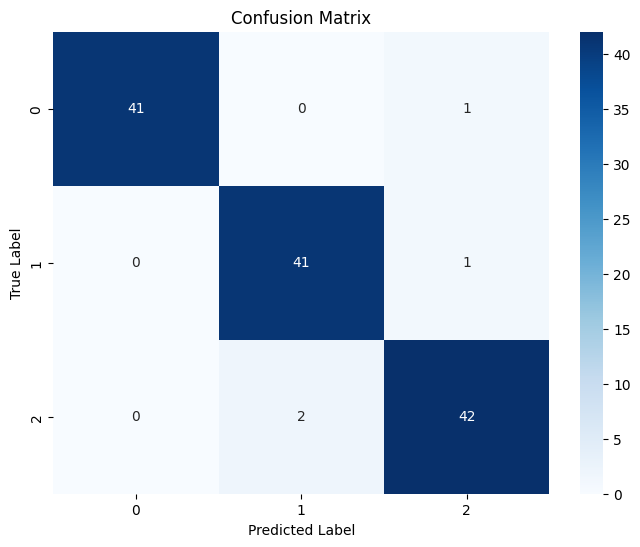

In [18]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

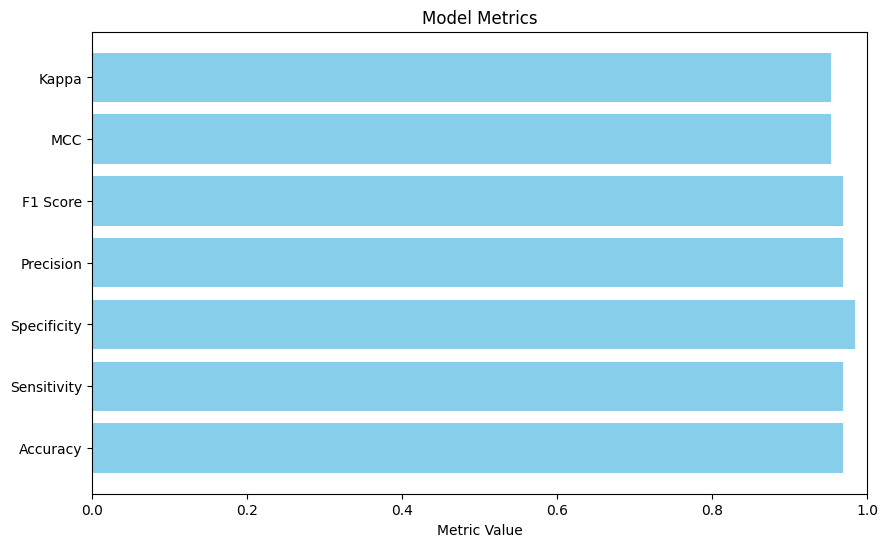

In [19]:
# Plot Metrics
metrics = [accuracy, sensitivity, specificity, precision, f1, mcc, kappa]
metric_names = ["Accuracy", "Sensitivity", "Specificity", "Precision", "F1 Score", "MCC", "Kappa"]

plt.figure(figsize=(10, 6))
plt.barh(metric_names, metrics, color="skyblue")
plt.xlabel("Metric Value")
plt.title("Model Metrics")
plt.xlim(0, 1)  # Metrics are between 0 and 1
plt.show()

In [20]:
epochs = range(1, len(pretrained_vit_results['train_loss']) + 1)

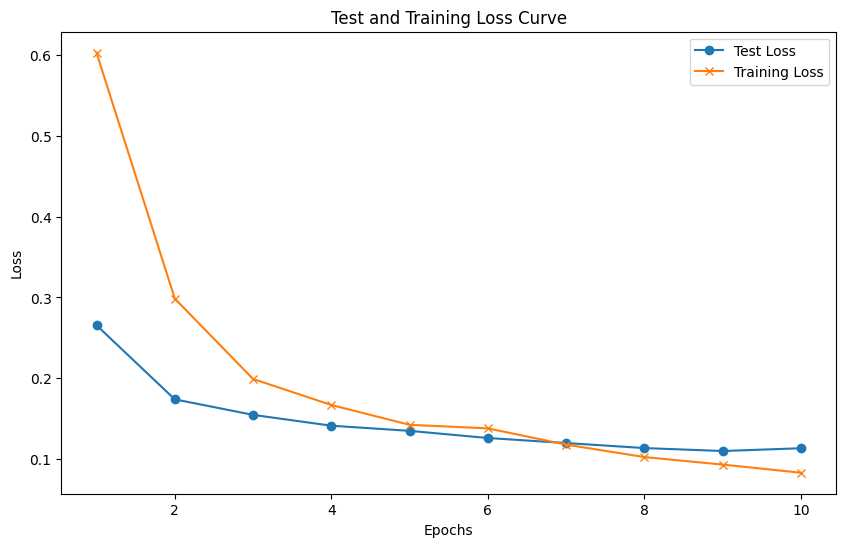

Test Loss: 0.11354625876992941
Training Loss: 0.0832720057463602


In [21]:
# Test Loss Curve
plt.figure(figsize=(10, 6))
plt.plot(epochs, pretrained_vit_results['test_loss'], label='Test Loss', marker='o')
plt.plot(epochs, pretrained_vit_results['train_loss'], label='Training Loss', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Test and Training Loss Curve')
plt.legend()
plt.show()

print("Test Loss:", pretrained_vit_results['test_loss'][-1])
print("Training Loss:", pretrained_vit_results['train_loss'][-1])

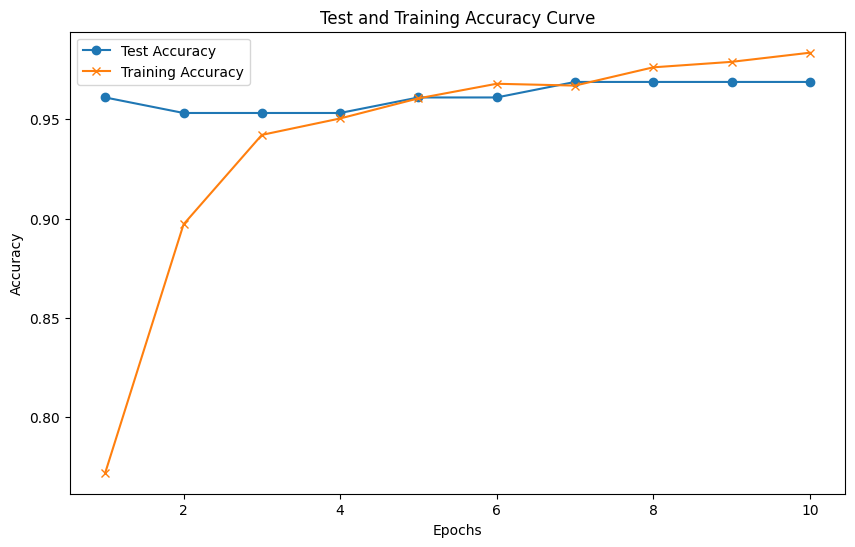

Test Accuracy: 0.96875
Training Accuracy: 0.9834558823529411


In [22]:
# Test Accuracy Curve
plt.figure(figsize=(10, 6))
plt.plot(epochs, pretrained_vit_results['test_acc'], label='Test Accuracy', marker='o')
plt.plot(epochs, pretrained_vit_results['train_acc'], label='Training Accuracy', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test and Training Accuracy Curve')
plt.legend()
plt.show()
print("Test Accuracy:", pretrained_vit_results['test_acc'][-1])
print("Training Accuracy:", pretrained_vit_results['train_acc'][-1])

## That's the power of transfer learning!

We managed to get outstanding results with the same model architecture, except our custom implementation was trained from scratch (worse performance) and this feature extractor model has the power of pretrained weights from ImageNet behind it.

# Let's make Prediction:

In [23]:
# import requests

# # Import function to make predictions on images and plot them
# from going_modular.going_modular.predictions import pred_and_plot_image

# # Setup custom image path
# custom_image_path = "/content/normal.jpg"

# # Predict on custom image
# pred_and_plot_image(model=pretrained_vit,
#                     image_path=custom_image_path,
#                     class_names=class_names)

In [24]:
# # Import function to make predictions on images and plot them
# from going_modular.going_modular.predictions import pred_and_plot_image

# # Setup custom image path
# custom_image_path = "/content/normal_trick_1.jpg"

# # Predict on custom image
# pred_and_plot_image(model=pretrained_vit,
#                     image_path=custom_image_path,
#                     class_names=class_names)